In [2]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

C:\Users\HP\AppData\Local\Temp\ipykernel_102248\2317971057.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start="1993-01-01")
[*********************100%***********************]  1 of 1 completed


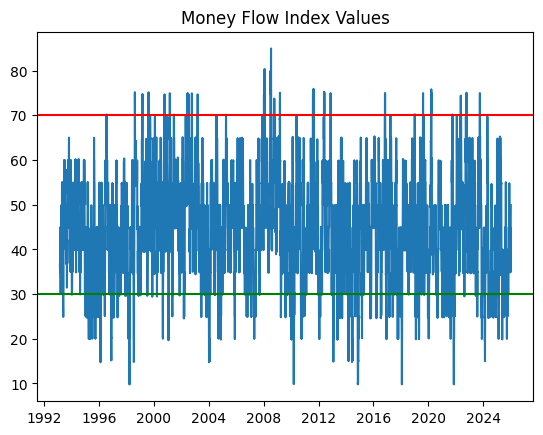

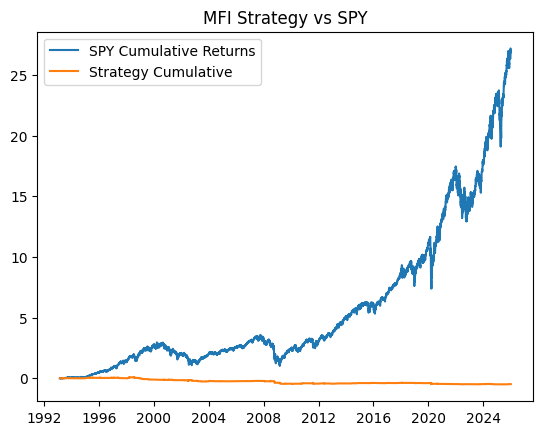

In [44]:
TICKER = 'SPY'
MFI_LENGTH = 20
OVERBOUGHT = 70
OVERSOLD = 30
LOOKBACK = 10000

def get_data(TICKER):
    df = yf.download(TICKER, start="1993-01-01") 
    df.columns = df.columns.get_level_values(0)

    # only return the subset of data you are interested in
    return df.iloc[-LOOKBACK:, :]

def add_MFI(df, length = MFI_LENGTH):
    df['Average_Price'] = (df['High'] + df['Low'] + df['Close'])/3
    df['Money_Flow']= df['Volume'] * df['Average_Price']

        #Initialize empty flows
    df['Positive_Flow'] = 0
    df['Negative_Flow'] = 0

    df['Positive_Flow']= np.where(df['Average_Price'].diff() > 0, df['Average_Price'], 0)
    df['Negative_Flow']= np.where(df['Average_Price'].diff() < 0, df['Average_Price'], 0)

    #money flow ratio
    mfr = df['Positive_Flow'].rolling(length).sum() /  df['Negative_Flow'].rolling(length).sum()

    #add money flow column
    df['MFI'] =100 - (100 / (1 + mfr))
   

     #plot the Money Flow index
    plt.plot(df['MFI'])
    plt.axhline(OVERBOUGHT, color = 'red')
    plt.axhline(OVERSOLD, color = 'green')
    plt.title('Money Flow Index Values')
    
    return df.dropna()

def add_strategy(df, overbought = OVERBOUGHT, oversold= OVERSOLD):
    df['Strategy'] = 0
    df['Strategy'] = np.where(df['MFI'] > overbought, -1,
                     np.where(df['MFI'] < oversold, 1, 0))

    #shift back to make sure we have seen the signal
    df['Strategy'] = df['Strategy'].shift(1)

    return df

def test_strategy(df):
    df['Asset_Returns'] = (1+ df['Close']. pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1+ df['Close']. pct_change() * df['Strategy']).cumprod() - 1

    #plot the strategy returns
    plt.figure()
    plt.plot(df['Asset_Returns'])
    plt.plot(df['Strategy_Returns'])
    plt.legend([f'{TICKER} Cumulative Returns', 'Strategy Cumulative'])
    plt.title(f'MFI Strategy vs {TICKER}')
    return df



def main():
    df = get_data(TICKER)
    df = add_MFI(df)
    df = add_strategy(df, overbought = OVERBOUGHT, oversold= OVERSOLD)
    df = test_strategy(df)
    return df

df = main()



In [43]:
df

Price,Close,High,Low,Open,Volume,Average_Price,Money_Flow,Positive_Flow,Negative_Flow,MFI,Strategy,Asset_Returns,Strategy_Returns
Date,,,,,,,,,,,,,
1993-02-26,24.500034,24.517276,24.379345,24.517276,66200,24.465552,1.619620e+06,24.465552,0.000000,36.657746,NaN,NaN,NaN
1993-03-01,24.431063,24.586235,24.396580,24.586235,66500,24.471293,1.627341e+06,24.471293,0.000000,34.821279,1.0,-0.002815,-0.002815
1993-03-02,24.793135,24.793135,24.413824,24.448307,182400,24.666698,4.499206e+06,24.666698,0.000000,34.799578,1.0,0.011963,0.011963
1993-03-03,24.896576,24.913817,24.793128,24.827610,280100,24.867840,6.965482e+06,24.867840,0.000000,34.768509,1.0,0.016185,0.016185
1993-03-04,24.758654,24.931068,24.758654,24.931068,89500,24.816125,2.221043e+06,0.000000,24.816125,39.827600,1.0,0.010556,0.010556
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-26,690.309998,691.659973,689.270020,690.640015,41613300,690.413330,2.873038e+10,690.413330,0.000000,34.857916,1.0,27.175879,-0.554488
2025-12-29,687.849976,689.200012,686.070007,687.539978,62559500,687.706665,4.302259e+10,0.000000,687.706665,39.881387,1.0,27.075470,-0.556076
2025-12-30,687.010010,688.559998,686.580017,687.450012,47160700,687.383341,3.241748e+10,0.000000,687.383341,39.919805,1.0,27.041186,-0.556618
